In [1]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data, get_gparams
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
from optim     import get_learning_cbfs_lagrangian_hj, get_h, get_h_curr, get_learning_cbfs_lagrangian_hj_optim, cvx_train_cbf, clarabel_solve_cbf
from utils     import plot_cbf, plot_angles, _plot_angles, quad_plot, union, intersection, difference

# HJB imports 
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

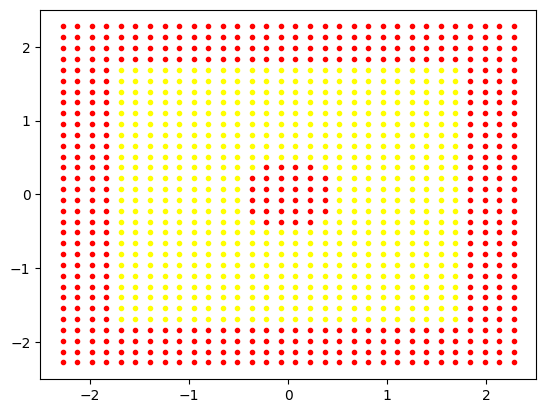

spacing: 0.14677419354838708


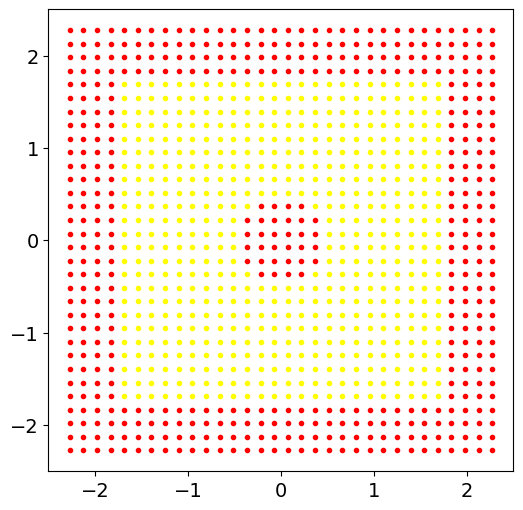

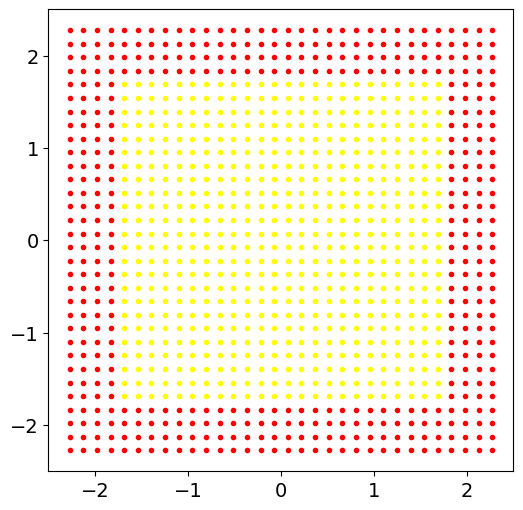

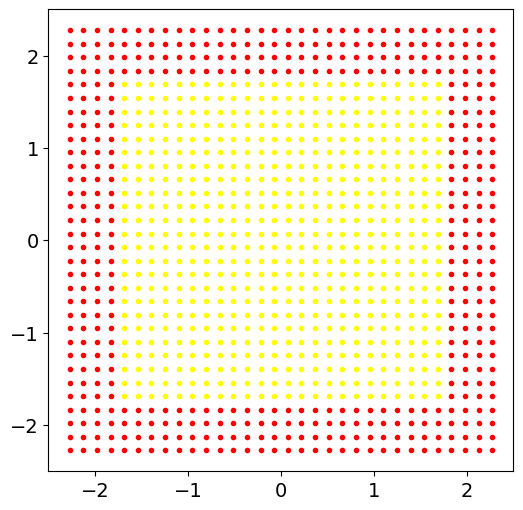

In [2]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 50
unsafe_margin = 0.3
thn           = 24

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("spacing:", spacing)
lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (thn     ,)

hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1024, 2)
(32, 32, 24)


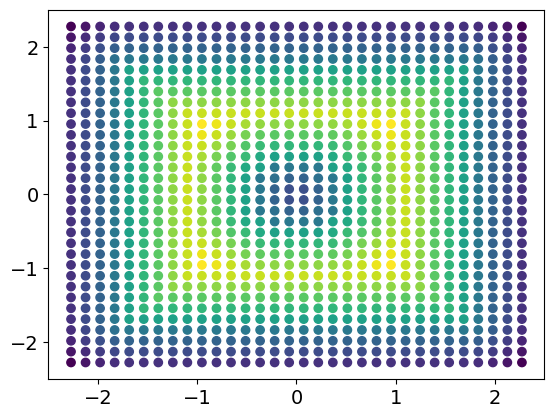

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
############################
### Configure HJB Solver ###
############################

gamma  = 0.20
cbvf   = True
umax   = 0.40
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(gamma=gamma, V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|############################################################################################################################################| 500.0000/500.0 [00:03<00:00, 135.42sim_s/s]


<Figure size 640x480 with 0 Axes>

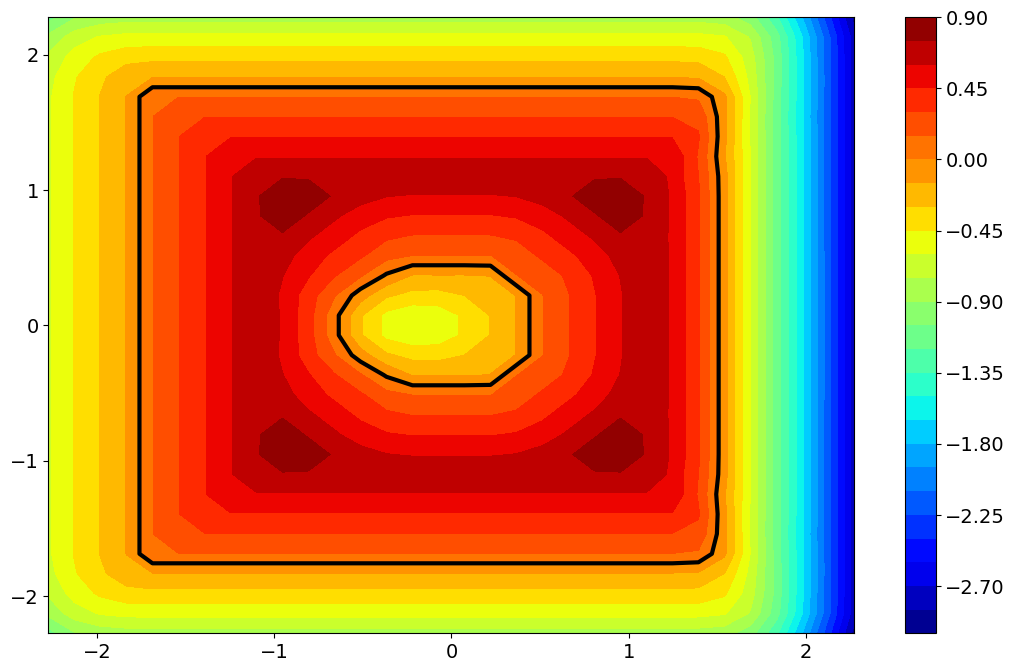

In [6]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

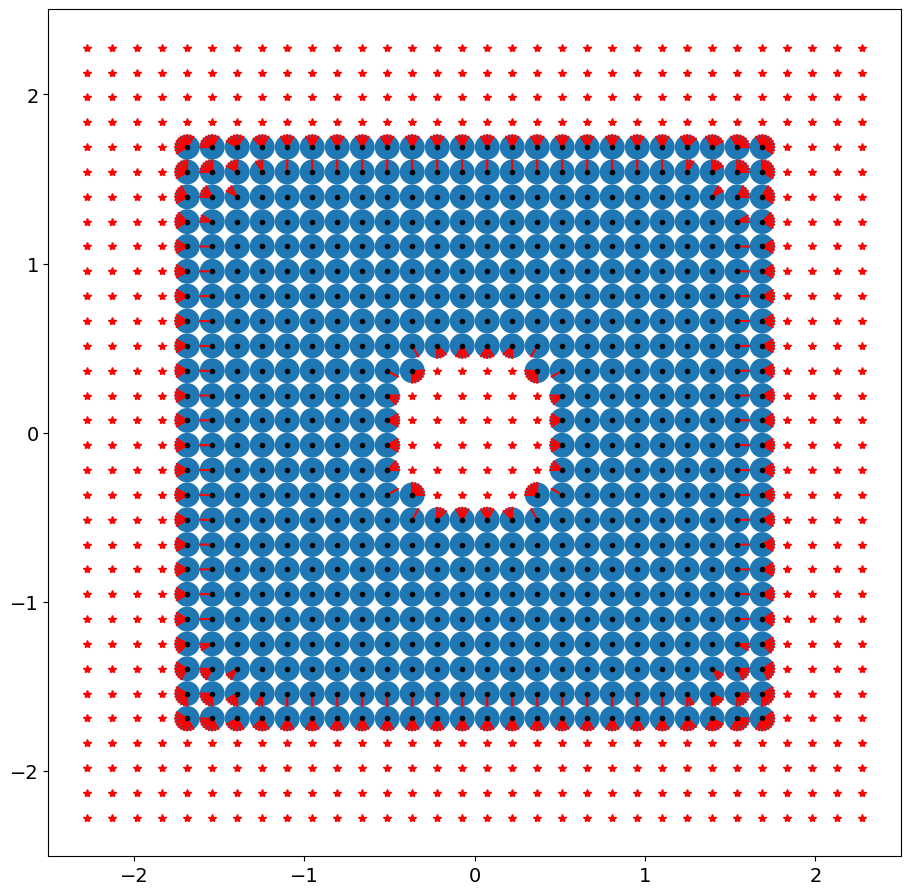

In [7]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [8]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [9]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|############################################################################################################################################| 500.0000/500.0 [00:04<00:00, 116.78sim_s/s]


In [10]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [35]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-0.5   # offset (-0.5)
s     = 0.90  #0.75# csrbf zeroing
nm    = 0.20  # nm * n_safe = number of neighbors to consider
pct   = 0.35  # num neighber percentile under which boundary
mult  = 2
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
gamma = gamma # defined w/ hjb above
solver        ='CLARABEL'
sensor_radius = 1.1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            utype         = utype,
                                                                            umax          = umax,
                                                                            gamma         = gamma,
                                                                            solver        = solver,
                                                                            spacing       = spacing,
                                                                            obstacles     = obstacles)

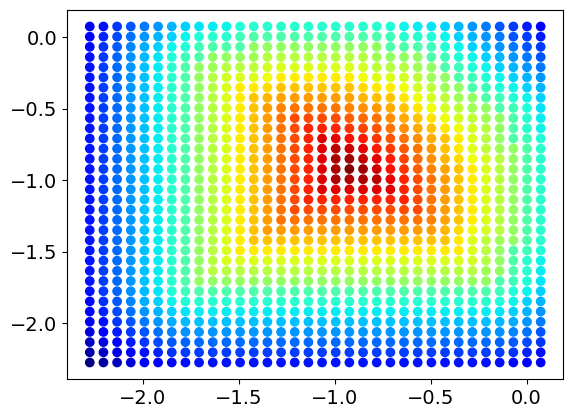

100%|#############################################################################################################################################| 500.0000/500.0 [00:05<00:00, 93.74sim_s/s]


<Figure size 640x480 with 0 Axes>

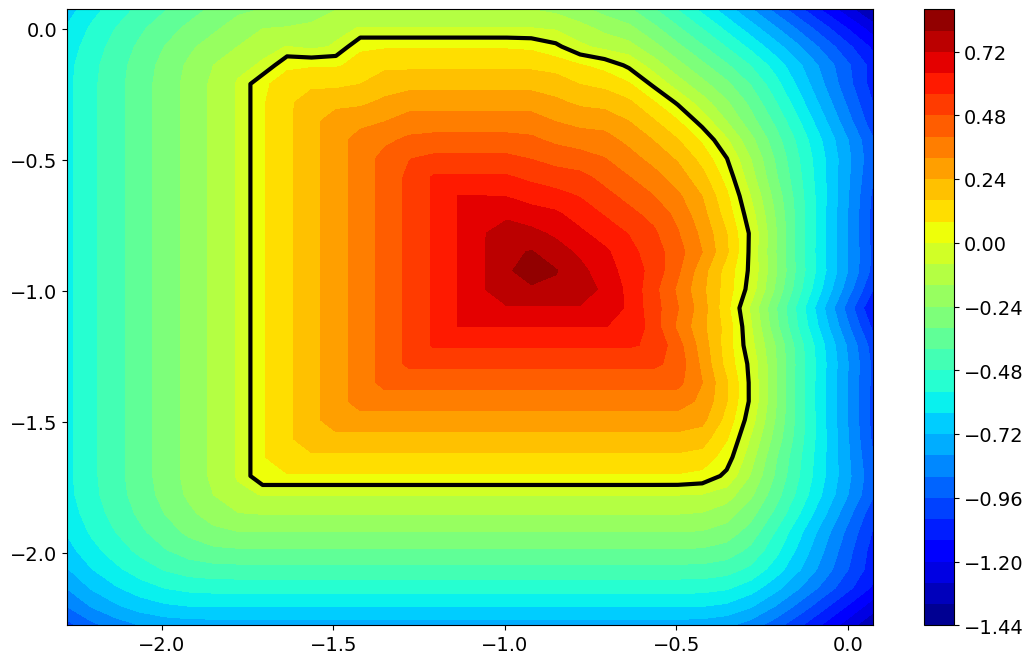

In [36]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
scan_funcs = [in_scan_f]
samples, gparams,\
is_obs_sample, x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
sample_funcs = [is_obs_sample]
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

In [37]:
vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
levels = np.linspace(vmin, vmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(loc_hjb_grid.coordinate_vectors[0],
                 loc_hjb_grid.coordinate_vectors[1],
                 loc_V[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(loc_hjb_grid.coordinate_vectors[0],
                loc_hjb_grid.coordinate_vectors[1],
                loc_V[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, loc_V.shape[-1], interval=50).to_html5_video())
plt.close()
animation

In [38]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.01   # numerical integration timestep
tol  = 0.10    # h-value at which to halt approach
eps  = 0
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 20      # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
start time is 0


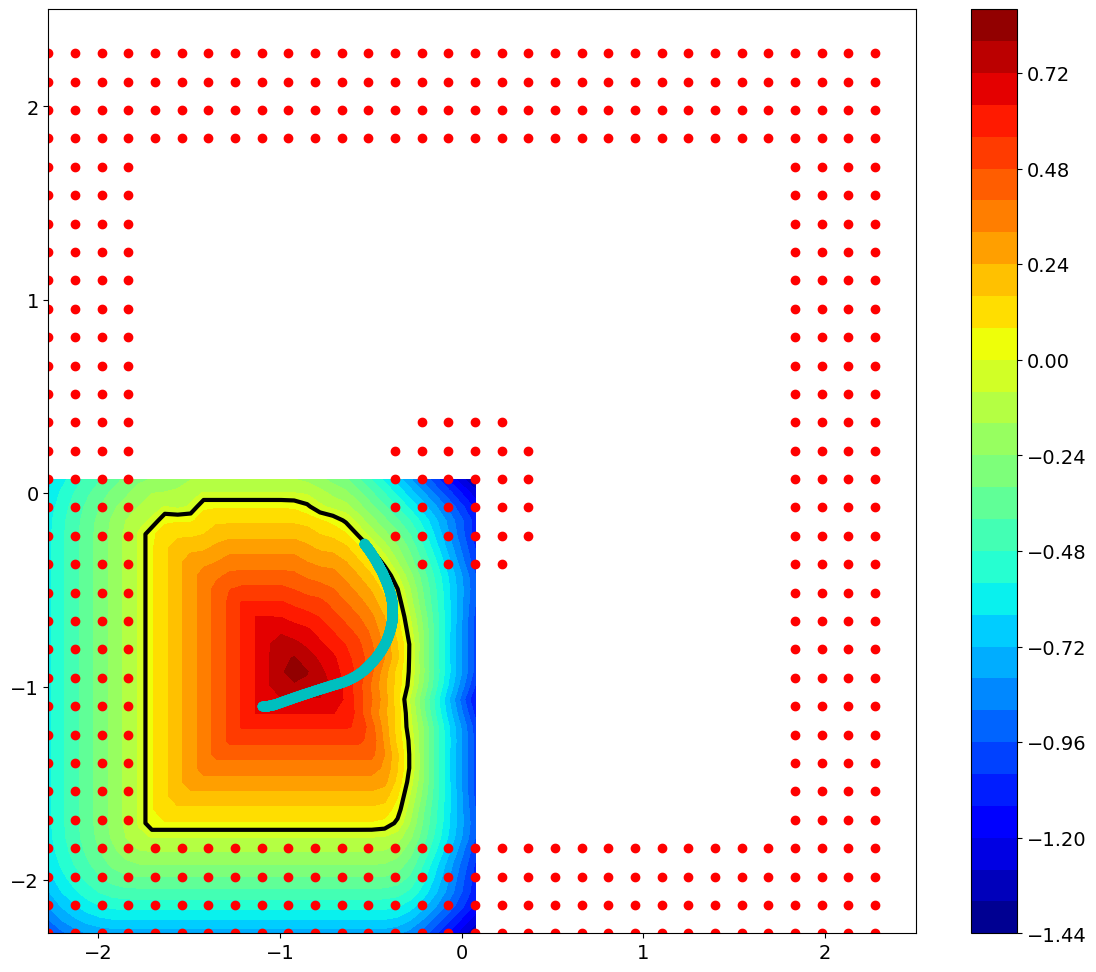

new position is [-0.53928733 -0.25900126  2.28400564]


ValueError: operands could not be broadcast together with shapes (1,3) (1,0) 

In [39]:
########################
### Safe Exploration ###
########################

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj,usig = a.goto(targets[i], T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps, cbvf=True, grid=loc_hjb_grid, V=loc_V, bicycle=True)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            traj,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams, is_obs_sample,\
    x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()
    
    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)

    all_C = union(all_C, C)
    plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [ ]:
#vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

In [ ]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()

In [ ]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, thn, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), pct, bicycle=True) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], angle=a.pos[-1], obstacles=obstacles)
_plot_angles(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], grid, hjb_grid, obs_dict)

In [ ]:
#############################
### Plot velocity curves ####
#############################
import copy

a2 = copy.copy(a)
a2.thetas = [all_theta]
a2.centers= [all_C]

start_pos = np.array([-1.2 ,-1, 0])
target    = np.array([1, 0, np.pi])
a.pos = start_pos
a2.pos= start_pos

DT   = 0.001
tol  = 0.1
tend = 30
T    = 0.1
traj ,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
traj2,usig2= a2.goto(target, T=T, tend=tend, tol=tol, angle=a2.pos[-1], manual=True, DT=DT, eps=eps)  


v1 = np.linalg.norm(np.vstack((traj[1:, :-1],np.array([0,0])))  - traj, axis=1)/DT
v2 = np.linalg.norm(np.vstack((traj2[1:,:-1],np.array([0,0])))  - traj2, axis=1)/DT
plt.plot(v1[:-1], color="red", label="max of local cbfs")
plt.plot(v2[:-1], color="blue", label="baseline")
plt.ylabel("velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(usig , color="red" , label="max cbf, |u|" )
plt.plot(usig2, color="blue", label="baseline, |u|")
plt.ylabel("norm of control")
plt.xlabel("time")
plt.legend()
plt.show()

In [ ]:
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a2)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation